In [47]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
import scipy
from pathlib import Path
import h5py
import numpy as np
import torch
from torchvision import transforms
from scipy.signal.windows import gaussian
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torch.fft
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import copy

In [48]:
# Dataset path
dataset_path = Path("/kaggle/input/dataset/data") #when you load this again somwhere make sure the path is correct

# Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
print("hello")
# Storage
images = []
labels = []

# Helper to extract scalar from h5py
def read_scalar(h5obj):
    return int(np.array(h5obj)[0][0])
#print("hiby")
# Load .mat files
for file in dataset_path.glob("*.mat"):
   ## print("nai")
    with h5py.File(file, 'r') as f:
        # The structure may look like: /cjdata/label, /cjdata/image, etc.
        label = read_scalar(f['cjdata']['label'])
        # print("hi")
        # cjdata.image is stored column-major (Fortran order), so we transpose it
        image = np.array(f['cjdata']['image']).T.astype(np.float32)
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        image = np.stack([image]*3, axis=-1)  # Grayscale to RGB

        img_tensor = transform(image)
        images.append(img_tensor)
        labels.append(label)

# Convert to tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)

print(f"Loaded {images_tensor.shape[0]} images.")
print(f"Sample image shape: {images_tensor[0].shape}")
print(f"Labels: {labels_tensor.unique().tolist()}")

hello
Loaded 3064 images.
Sample image shape: torch.Size([3, 256, 256])
Labels: [1, 2, 3]


In [49]:
labels_tensor = torch.tensor(labels) - 1 # for model training purpose

In [50]:
print(f"Labels: {labels_tensor.unique().tolist()}")
print(images_tensor[0].shape)

Labels: [0, 1, 2]
torch.Size([3, 256, 256])


In [51]:
images_tensor[0].shape

torch.Size([3, 256, 256])

In [52]:
images_tensor.shape

torch.Size([3064, 3, 256, 256])

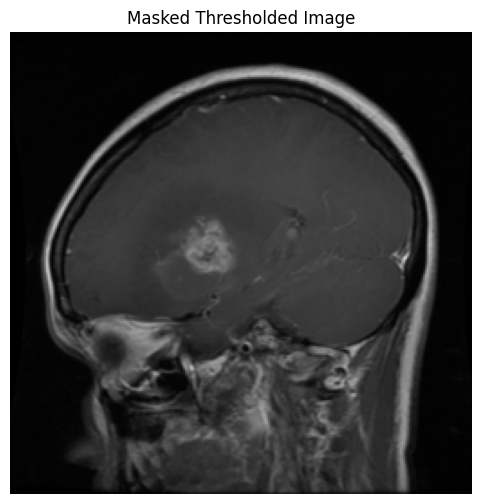

In [53]:


# Assuming masked_thresholded is your tensor with shape [3, 256, 256]

# Convert tensor to PIL Image for proper display
img_pil = TF.to_pil_image(images_tensor[2].cpu())

plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.title("Masked Thresholded Image")
plt.axis('off')
plt.show()

In [54]:


class CustomTensorDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, transform=None):
        self.images = images_tensor
        self.labels = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [55]:

#for augmentation, if you wanna apply any of them in future, but here I am not gonna apply
mri_augmentation = transforms.Compose([
    transforms.RandomAffine(
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=5
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.03), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [56]:
#custom_dataset = CustomTensorDataset(images_tensor, labels_tensor, mri_augmentation) # here the transform is for data augmentation
# if we want to apply any data-augmentation, we can do it here inside transform

# Example: get first image and label
#image, label = custom_dataset[0]

In [57]:
custom_dataset = CustomTensorDataset(images_tensor, labels_tensor)

In [58]:


def split_dataset(custom_dataset, train_ratio=0.7, val_ratio=0.2, seed=42):
    """
    Splits a dataset into train, validation, and test sets based on provided ratios.

    Args:
        custom_dataset (Dataset): The full dataset to be split.
        train_ratio (float): Proportion of dataset to use for training.
        val_ratio (float): Proportion of dataset to use for validation.
        seed (int): Seed for reproducibility.

    Returns:
        tuple: (train_data, val_data, test_data)
    """
    total_size = len(custom_dataset)
    generator = torch.Generator().manual_seed(seed)

    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size  # Ensure full coverage

    train_data, val_data, test_data = random_split(
        custom_dataset, [train_size, val_size, test_size], generator=generator
    )

    print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")
    return train_data, val_data, test_data

In [59]:
train_data, val_data, test_data = split_dataset(custom_dataset)

Train: 2144, Validation: 612, Test: 308


In [60]:
def print_class_distribution(dataset, datasetname):
    counter = {0:0, 1:0, 2:0}
    for data in dataset:
        num = data[1].item()
        counter[num] = counter[num] + 1
    print(datasetname, "class 0", counter[0])
    print(datasetname, "class 1", counter[1])
    print(datasetname, "class 2", counter[2])
#print_class_distribution(train_data, "train")
#print_class_distribution(val_data, "validation")
#print_class_distribution(test_data, "test_data")

In [61]:


# Set your desired batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [62]:
# lets print our accelerator cuda-gpu, if that is not found go for cpu
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"using device {device}") # we are using gpu

using device cuda


In [63]:
# Number of classes (update this based on your problem)
num_classes = 3

#defining the 2_hidden_layer_Neural_Network
class Simple_2_hidden_layer_NN(nn.Module):
    def __init__(self, img_height, img_weight, img_channels, num_classes):
        super(Simple_2_hidden_layer_NN, self).__init__()
        self.flatten_aka_first_hidden_layer = nn.Flatten()
        self.second_hidden_layer = nn.Linear(img_height * img_weight * img_channels, 128)
        self.relu = nn.ReLU()
        self.classification_layer = nn.Linear(128, num_classes)
      #  self.softmax = nn.Softmax(dim=1)  # Keep only if not using CrossEntropyLoss

    def forward(self, x):
        x = self.flatten_aka_first_hidden_layer(x)
        x = self.second_hidden_layer(x)
        x = self.relu(x)
        x = self.classification_layer(x)
        return x
      #  x = self.softmax(x)  # Remove if using CrossEntropyLoss

In [64]:
model = Simple_2_hidden_layer_NN(img_height=256, img_weight=256, img_channels=3, num_classes=num_classes).to(device)
#fourier_original_images_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)
#fourier_canny_custom_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)
#canny_custom_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)

In [65]:
#print(custom_resnet50_model)

In [66]:
# now we need a loss function(to calculate error) and an optimizer(or gradient descent algorithm)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#fourier_canny_loss_function = nn.CrossEntropyLoss()
#fourier_canny_optimizer = torch.optim.Adam(fourier_canny_custom_resnet50_model.parameters(), lr=1e-4)

#canny_loss_function = nn.CrossEntropyLoss()
#canny_optimizer = torch.optim.Adam(canny_custom_resnet50_model.parameters(), lr=1e-4)

In [67]:
# don't delete it. please kindly keep the below code.

# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)

#         # Compute prediction error
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         if batch % 32 == 0:
#             loss, current = loss.item(), (batch + 1) * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [68]:
# don't delete it. please kindly keep the code.

# def validation(dataloader, model, loss_fn, return_metrics=False):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     validation_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#            # print("pred", pred, pred.shape)
#             validation_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item() # here 1 means search for max value through the column for each row
#     validation_loss /= num_batches
#     correct /= size
#     accuracy = 100 * correct
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
#     if return_metrics:
#         return validation_loss, accuracy

In [69]:
# dont delete it. keep the below codes

# def runEpochAndFinalTest(epochs, model, loss_function, optimizers, train_loader, val_loader, test_loader, model_name):

#     best_val_acc = 0.0  # Or use float('inf') for best_val_loss
#     best_model_state = None  # To store best model
#     model_save_path = model_name + "best_model.pth"
#     for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
#         train(train_loader, model, loss_function, optimizers)
#         val_loss, val_acc = validation(val_loader, model, loss_function, return_metrics=True)
#         # Save best model based on validation accuracy
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             best_model_state = copy.deepcopy(model.state_dict())
#             torch.save(best_model_state, model_save_path)
#             print(f"✅ Best model saved at epoch {t + 1} with accuracy: {val_acc:.4f}")
#         print("Done!")
#     model.load_state_dict(torch.load(model_save_path))
#     model.eval()
#     validation(test_loader, model, loss_function) # final test_data accuracy check

In [70]:
import torch
import copy
import matplotlib.pyplot as plt

# Modified train function to return loss & accuracy
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0.0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 32 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / size
    return epoch_loss, epoch_acc


# Modified validation function to return loss & accuracy
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    validation_loss, correct = 0.0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = validation_loss / num_batches
    accuracy = 100 * correct / size
    return avg_loss, accuracy


# Training loop with tracking and plotting
def runEpochAndFinalTest(epochs, model, loss_function, optimizers, train_loader, val_loader, test_loader, model_name):
    best_val_acc = 0.0
    best_model_state = None
    model_save_path = model_name + "_best_model.pth"

    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss, train_acc = train(train_loader, model, loss_function, optimizers)
        val_loss, val_acc = validation(val_loader, model, loss_function)

        # Save metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, model_save_path)
            print(f"✅ Best model saved at epoch {t + 1} with accuracy: {val_acc:.4f}")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("Done!")

    # Load best model and test
    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_acc = validation(test_loader, model, loss_function)
    print(f"Final Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


Epoch 1
-------------------------------
loss: 1.121285  [   32/ 2144]
loss: 0.889611  [ 1056/ 2144]
loss: 0.685759  [ 2080/ 2144]
✅ Best model saved at epoch 1 with accuracy: 74.5098
Train Loss: 3.3119, Train Acc: 61.85%
Val Loss: 0.6249, Val Acc: 74.51%
Done!
Epoch 2
-------------------------------
loss: 0.701554  [   32/ 2144]
loss: 0.945581  [ 1056/ 2144]
loss: 0.268157  [ 2080/ 2144]
Train Loss: 0.5282, Train Acc: 77.75%
Val Loss: 0.7285, Val Acc: 70.10%
Done!
Epoch 3
-------------------------------
loss: 0.490483  [   32/ 2144]
loss: 0.721235  [ 1056/ 2144]
loss: 0.653319  [ 2080/ 2144]
✅ Best model saved at epoch 3 with accuracy: 76.7974
Train Loss: 0.4989, Train Acc: 79.20%
Val Loss: 0.6113, Val Acc: 76.80%
Done!
Epoch 4
-------------------------------
loss: 0.272005  [   32/ 2144]
loss: 0.628231  [ 1056/ 2144]
loss: 0.566628  [ 2080/ 2144]
✅ Best model saved at epoch 4 with accuracy: 80.7190
Train Loss: 0.4777, Train Acc: 79.38%
Val Loss: 0.4688, Val Acc: 80.72%
Done!
Epoch 5
-

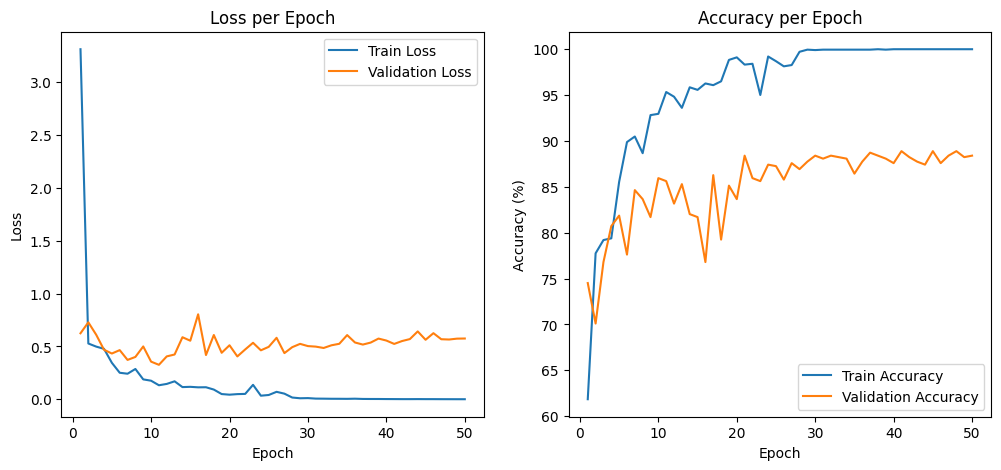

In [71]:
runEpochAndFinalTest(50, model, loss_function, optimizer, train_loader, val_loader, test_loader, model_name = "2_hidden_layer_model_relu")